# Creating Dataset and Folder Structure

In [1]:
import os, shutil, glob

dataset_dir = './arcDataset/' # original dataset directory path
# create folder for dataset
base_dir = './dataset'
os.mkdir(base_dir)

# create train folder
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# create test folder
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [3]:
folder_names = os.listdir(dataset_dir)
for folder_name in folder_names:
    # ignore .DS_Store for macOS
    if (folder_name == '.DS_Store'):
        continue
    
    #create class folders
    os.mkdir(os.path.join(train_dir, folder_name))
    os.mkdir(os.path.join(test_dir, folder_name))

    path = os.path.join(dataset_dir, folder_name, "*") # to glob relevant folder
    image_paths = glob.glob(path) # lists the images in class folder

    for i, image_path in enumerate(image_paths):
        image_name = os.path.basename(image_path).split('/')[-1] # get file name

        # Split 1/10 of the data for testing
        if i % 10 == 0:
            dst = os.path.join(test_dir, folder_name, image_name)
        else:
            dst = os.path.join(train_dir, folder_name, image_name)

        shutil.copy(image_path, dst)

# Prepare Data for Keras with ImageDataGenerator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.2) # data augmentation can be added
test_datagen = ImageDataGenerator()

# split validation and training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=20, class_mode='categorical', subset='training')
validation_generartor = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=20, class_mode='categorical', subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=20, class_mode='categorical')

Found 3451 images belonging to 25 classes.
Found 852 images belonging to 25 classes.
Found 491 images belonging to 25 classes.


# Create Sequential Model
## Create Pretrained Model (MobileNetV3Large)

In [5]:
from keras.applications import MobileNetV3Large
pretrained = MobileNetV3Large(weights='imagenet', input_shape=(224,224,3), include_top=False)
pretrained.trainable = False # freeze model layers
pretrained.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

## Create Keras Model

In [7]:
from keras import models, layers

model = models.Sequential()
model.add(pretrained)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')) # L2 regularization
model.add(layers.Dense(25, activation='softmax')) # output layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_2 (Dropout)         (None, 47040)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               12042496  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                      

## Model Fitting

In [8]:
from keras import optimizers
model.compile(optimizer=optimizers.Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
batch_size = 20
history = model.fit(train_generator, steps_per_epoch=train_generator.samples//batch_size,
                    validation_data=validation_generartor, validation_steps=validation_generartor.samples//batch_size,
                    epochs=10)

Epoch 1/10
172/172 [==============================] - 17s 99ms/step - loss: 18.1940 - accuracy: 0.4395 - val_loss: 12.9490 - val_accuracy: 0.4667
Epoch 2/10
172/172 [==============================] - 17s 96ms/step - loss: 19.7539 - accuracy: 0.4529 - val_loss: 12.7371 - val_accuracy: 0.4810
Epoch 3/10
172/172 [==============================] - 16s 95ms/step - loss: 16.6482 - accuracy: 0.5357 - val_loss: 19.1878 - val_accuracy: 0.4726
Epoch 4/10
172/172 [==============================] - 16s 95ms/step - loss: 15.5931 - accuracy: 0.5955 - val_loss: 16.9582 - val_accuracy: 0.5107
Epoch 5/10
172/172 [==============================] - 16s 95ms/step - loss: 13.4021 - accuracy: 0.6535 - val_loss: 20.3139 - val_accuracy: 0.5310
Epoch 6/10
172/172 [==============================] - 16s 95ms/step - loss: 12.5447 - accuracy: 0.7001 - val_loss: 18.8467 - val_accuracy: 0.5405
Epoch 7/10
172/172 [==============================] - 16s 96ms/step - loss: 11.5582 - accuracy: 0.7196 - val_loss: 21.0502 -

### Validation vs Training Accuracy

In [11]:
def compare_metrics(history):
    val_acc = history.history['val_accuracy']
    acc = history.history['accuracy']
    epochs = range(1, len(history.epoch) + 1)
    import matplotlib.pyplot as plt
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.legend()
    plt.show();

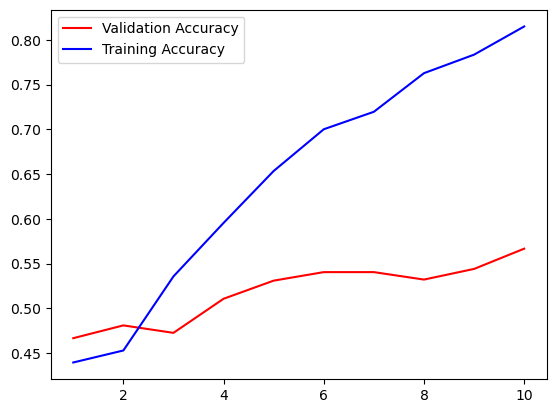

In [12]:
compare_metrics(history)